# Lesson 10 - Sentiment Analysis

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lawrence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lawrence/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]

# examine dataframe head
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


##### Text preparation

In [3]:
# Create a function for text cleaning
# cleaning steps include: remove_non_ascii, lowercase, remove_punctuation, remove_numbers, 
# strip_whitespace, remove_stopwords, stem_words
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

In [4]:
# use sentiment '1' or '0' to indicate positive or negative sentiment
# change sentiment in above dataframe from '4' to '1'
print('sentiment labels before replacement:')
print(df['sentiment_label'].unique())

df['sentiment_label']=df['sentiment_label'].replace(4,1)
print('\nsentiment labels after replacement:')
print(df['sentiment_label'].unique())

print('\nCount of sentiment 1 (positive) and 0 (negative)')
print(df['sentiment_label'].value_counts())

# examine dataframe head
df.head()

sentiment labels before replacement:
[4 0]

sentiment labels after replacement:
[1 0]

Count of sentiment 1 (positive) and 0 (negative)
1    80000
0    80000
Name: sentiment_label, dtype: int64


,sentiment_label,tweet_text
0,1,"@elephantbird Hey dear, Happy Friday to You A..."
1,1,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [5]:
# Convert a copy of the tweets as list for use later
tweet_data = df.values.tolist()

# clean tweets, using steps defined in the cleaning function
#steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace']
steps = step_list # all steps
print('order of cleaning steps used: {}'.format(steps))

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))
# examine dataframe, now with cleaned tweet
df.head()

order of cleaning steps used: ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace', 'remove_stopwords', 'stem_words']


,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday already ric...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting zeina cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach reckon hell play even he know noth...
3,0,@vaLewee I know! Saw it on the news!,valewee know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad httpwwwfabchannelcom closed one web servic...


#### Q1: Generate word cloud for positive sentiment.

In [6]:
# use wordcloud package to generate word clouds. wordcloud package also has built-in stopwords
more_stopwords = set(STOPWORDS)
# add 'im' to wordcloud stopwords; it is a frequent term in both positive and negative tweets
more_stopwords.update(['im']) 

word cloud for positive sentiment:


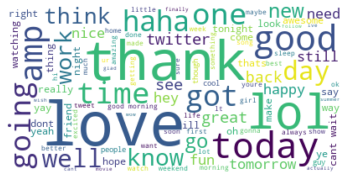

In [7]:
# generate word cloud for positive sentiment
print('word cloud for positive sentiment:')
positive_tweets_array = df[df['sentiment_label']==1]['clean_tweet']
positive_tweets_text = ' '.join(positive_tweets_array)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=72, max_words=100, relative_scaling=1, background_color='white',
                      stopwords=more_stopwords).generate(positive_tweets_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Q2: Generate word cloud for negative sentiment.

word cloud for negative sentiment:


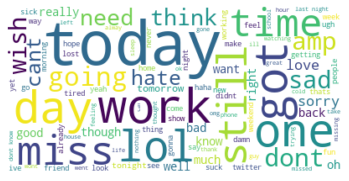

In [8]:
# generate word cloud for negative sentiment
print('word cloud for negative sentiment:')
negative_tweets_array = df[df['sentiment_label']==0]['clean_tweet']
negative_tweets_text = ' '.join(negative_tweets_array)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=72, max_words=100, relative_scaling=1, background_color='white', 
                      stopwords=more_stopwords).generate(negative_tweets_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Create a term document matrix (tdm), a representation of Bag of Words model.

In [9]:
# Create a document storage matrix
clean_texts = df['clean_tweet']
docs = {}
labels = []
for ix, row in enumerate(clean_texts):
    # Store the sentiment
    labels = tweet_data[ix][0]
    docs[ix] = row.split(' ')

# See a sample
print('Example entry: {}'.format(docs[np.random.choice(ix)]))

Example entry: ['faithgoddess', 'youre', 'welcome']


In [10]:
# keep track of how many unique words there are
num_nonzero = 0
vocab = set()

for word_list in docs.values():
    unique_terms = set(word_list)    # all unique terms of this tweet
    vocab.update(unique_terms)       # set union: add unique terms of this tweet
    num_nonzero += len(unique_terms) # add count of unique terms in this tweet

doc_key_list = list(docs.keys())

print('Our tweet-vocabulary has {} distinct words.'.format(len(vocab)))

# convert to numpy array
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

# keep track of how the vocab/term indices map to the matrix so that we can look them up later.
vocab_sorter = np.argsort(vocab)

# print a few words from voacb and sorted vocab
# print('Vocab: {}'.format(vocab[:5]))
# print('Sorted Vocab: {}'.format(vocab[vocab_sorter[:5]]))

Our tweet-vocabulary has 144957 distinct words.


In [11]:
# initialize sparse matrix:
num_docs = len(doc_key_list)
vocab_size = len(vocab)
# A COO matrix is just a tuple of data, row indices, and column indices. Everything else is assumed to be zero.
data = np.empty(num_nonzero, dtype=np.intc)     # all non-zero
rows = np.empty(num_nonzero, dtype=np.intc)     # row index
cols = np.empty(num_nonzero, dtype=np.intc)     # column index

ix = 0
# go through all documents with their terms
print('Computing full term-document matrix (sparse), please wait!')
for doc_key, terms in docs.items():
    # find indices to insert-into such that, if the corresponding elements were
    # inserted before the indices, the order would be preserved
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    n_vals = len(uniq_indices)  # = number of unique terms
    ix_end = ix + n_vals # Add count to index.

    data[ix:ix_end] = counts                  # save the counts (term frequencies)
    cols[ix:ix_end] = uniq_indices            # save the column index: index in 
    doc_ix = np.where(doc_key_list == doc_key)   # get the document index for the document name
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)  # save it as repeated value

    ix = ix_end  # resume with next document -> will add future data on the end.
print('Done!')

Computing full term-document matrix (sparse), please wait!
Done!


In [12]:
# Create the sparse coordinate matrix
doc_term_mat = coo_matrix((data, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.intc)

Since the document-term matrix is a matrix of counts of words (columns) in each document (rows), we want to remove words that don't occur very frequently across our corpus.

In [13]:
# count of how frequent a word is in all of our corpus is just the sum of each column.
word_counts = doc_term_mat.sum(axis=0)

# Look at how many words are above a specific cutoff
cutoff = 15
word_count_list = word_counts.tolist()[0]
# Find which column indices are above cutoff
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

print('Number of words with counts above {}: {}'.format(cutoff, len(col_cutoff_ix)))

Number of words with counts above 15: 5741


Shape of document-term matrix before trimming: (160000, 144957)
Shape of document-term matrix after trimming: (160000, 5741)

Before trimming, first 10 terms alphabetically: ['' 'aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaaa'
 'aaaaaaaaaaaa']
After trimming, first 10 terms alphabetically: ['' 'aa' 'aaa' 'aaaah' 'aaah' 'aah' 'aaron' 'ab' 'abandoned' 'abby']


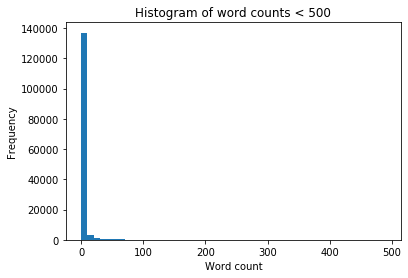

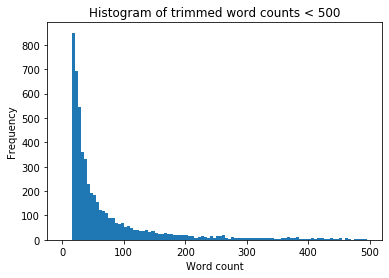

In [14]:
# Get the trimmed vocabulary
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])
# Re-do the vocab-sorter
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

print('Shape of document-term matrix before trimming: {}'.format(doc_term_mat.shape))

# Trim the document-term matrix
doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]

print('Shape of document-term matrix after trimming: {}'.format(doc_term_mat_trimmed.shape))

# Look at first 10 words alphabetically
print('\nBefore trimming, first 10 terms alphabetically: {}'.format(vocab[vocab_sorter[:10]]))
print('After trimming, first 10 terms alphabetically: {}'.format(vocab_trimmed[vocab_sorter_trimmed[0:10]]))

# bar graph of frequency of words before and after trimming
# Count of words for each appearance
hist_breaks = np.arange(0, 500, 10)
plt.hist(word_count_list, bins = hist_breaks)
plt.title('Histogram of word counts < 500')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Too many words appear few times. Check out trimmed.
trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
hist_breaks = np.arange(0, 500, 5)
plt.hist(trimmed_word_list, bins = hist_breaks)
plt.title('Histogram of trimmed word counts < 500')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

A cutoff of 15 was used because we get a visible drop off as shown in the histogram. 
We are left with ~6000 features, which is reasonable for the next model. 

##### TF-IDF transformation
Create a term frequency-inverse document frequency (TF-IDF) matrix from the data

In [15]:
# TF-IDF Transformation
# Look for rare words overall, but common inside individual documents. It is these words that hold a lot of meaning to the document they reside in.
# Declare the TFIDF vectorizer.
# Set max_features according to the trimming results
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=len(col_cutoff_ix), stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

#### Q3: Split data into 70% for training and 30% for testing.

In [16]:
# use TF-IDF weighted TDM as features for training a model to predict sentiment
# 70/30 train/test split on the TF-IDF sparse matrix:
y_targets = np.array([y[0] for y in tweet_data])
X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets, y_targets, test_size=0.3, random_state=42)

#### Q4: Build a classifier that classifies the sentiment of a sentence.

In [17]:
# Build a logistic regression model with elastic net regularization 
# using default alpha and l1_ratio
lr_reg = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
lr_reg.fit(X_train, y_train)

# model evaluation
# Compute results on the train and test set
train_probs = lr_reg.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr_reg.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7534553571428572
Test accuracy: 0.7445416666666667


#### Q5: What is the accuracy of your model when applied to testing data?

In [18]:
print('Test accuracy: {}'.format(test_acc))

Test accuracy: 0.7445416666666667


The train and test accuracies are reasonably close to one another, and the model does not appear to be noticably over trained.

Confusion matrix:
[[16884  7160]
 [ 5102 18854]]
             Class 1   -   Class 0
Precision: [0.76794324 0.72476359]
Recall   : [0.70221261 0.78702621]
F1       : [0.73360852 0.75461277]
Support  : [24044 23956]


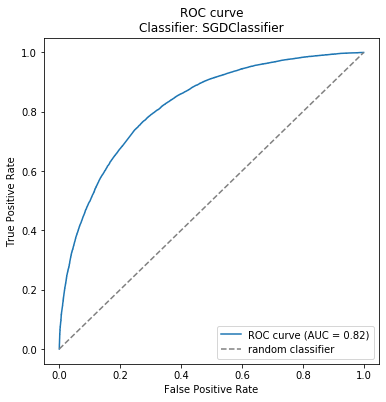

In [19]:
# examine confusion matrix-derived metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print('Confusion matrix:')
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

# Calculate the ROC curve and its AUC 
# get false positive rate, true posisive rate, probability thresholds
fpr, tpr, thrs = roc_curve(y_test, test_probs[:,1])
# get area under the curve
area_under_curve = auc(fpr, tpr)

# plot ROC curve with AUC score
plt.figure(figsize=[6,6])
plt.title('ROC curve\nClassifier: '+type(lr_reg).__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], c='gray', linestyle='--', label='random classifier')
plt.legend(loc="lower right")
plt.show()

##### Q6: What conclusions can you draw from the model?

The train and test accuracies are reasonably close to one another, and the model does not appear to be noticably over trained.


The accuracy of ~0.75, F1 scores of 0.73-0.75, and the area under the ROC curve of 0.82 suggest that the model achieves a reasonable level of accuracy in classifying sentiment of sentences/tweets. This is especially considering that there are only positive and negative expert labels, which do not account for neutral tweets (which conceivably may exist in the data). Furthermore, there could be many non-standard emotional words or sentiment-conveying emojis like "<3" that are removed during preprocessing, for example during cleaning steps or not meeting the frequency cutoff.

#### Q7: Is it better to have a model per source?

The biggest source of bias/error for NLP is the source data used. It is therefore better to have a model per source. For example, a model trained on tweets may work well for articles with a different level of grammer and vocabulary, or even in instances where the tweet text is modified while its meaning is kept the same.

#### Model applicability on future tweets

The model should be expected to achieve a similar level of performance as on the test set here, provided that future tweets are similar in terms of writing style to the current dataset. Otherwise, model hyperparameters, for example the frequency cutoff for a word in the corpus, will need to be tuned for optimal performance.